شروع و دریافت  اطلاعات

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Input
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import KFold

In [2]:
# تنظیمات
symbol = 'EURUSD'
timeframe = mt5.TIMEFRAME_H1
number_of_candles = 99999

mt5.initialize()
# login = '2424394'
# password = 'Aa@12345678'
# server = 'AMarkets-Real'
# mt5.login(login, password, server)


def get_data(symbol, timeframe, number_of_candles):
    if not mt5.initialize():
        print("Failed to initialize MT5")
        return None

    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, number_of_candles)
    mt5.shutdown()

    candles_data = pd.DataFrame(rates)
    candles_data['time'] = pd.to_datetime(candles_data['time'], unit='s')
    return candles_data


candles = get_data(symbol, timeframe, number_of_candles)

# تغییر نام
candles = candles.rename(
    columns={'open': 'O', 'high': 'H', 'low': 'L', 'close': 'C', 'tick_volume': 'vol'})
candles = candles.drop(columns=['real_volume', 'spread'])


candles

,time,O,H,L,C,vol
0,2008-08-12 09:00:00,1.48740,1.49140,1.48540,1.49040,1224
1,2008-08-12 10:00:00,1.49080,1.49130,1.48570,1.48680,1154
2,2008-08-12 11:00:00,1.48670,1.49220,1.48670,1.48750,1211
3,2008-08-12 12:00:00,1.48740,1.49040,1.48740,1.48900,727
4,2008-08-12 13:00:00,1.48910,1.49090,1.48770,1.49010,729
...,...,...,...,...,...,...
99994,2024-09-30 07:00:00,1.11582,1.11620,1.11582,1.11616,862
99995,2024-09-30 08:00:00,1.11616,1.11693,1.11613,1.11666,1278
99996,2024-09-30 09:00:00,1.11661,1.11689,1.11561,1.11681,1669
99997,2024-09-30 10:00:00,1.11679,1.11755,1.11593,1.11722,2139


پیدا کردن فراکتال ها

In [3]:
# استفاده از تابع fractals
left_n = 3  # تعداد کندل‌های چپ
right_n = 2  # تعداد کندل‌های راست

# تعریف تابع fractals


def fractal(candles, left_n, right_n):
    # ایجاد ستون‌های اولیه برای فراکتال‌ها با مقدار False
    candles['up_f'] = True
    candles['low_f'] = True

    # شناسایی فراکتال‌های بالا
    for i in range(1, left_n + 1):
        candles['up_f'] &= (candles['H'] >= candles['H'].shift(i))

    for j in range(1, right_n + 1):
        candles['up_f'] &= (candles['H'] >= candles['H'].shift(-j))

    # شناسایی فراکتال‌های پایین
    for i in range(1, left_n + 1):
        candles['low_f'] &= (candles['L'] <= candles['L'].shift(i))

    for j in range(1, right_n + 1):
        candles['low_f'] &= (candles['L'] <= candles['L'].shift(-j))

    # تبدیل فراکتال‌های بالا و پایین به مقادیر بولی
    candles['up_f'] = np.where(candles['up_f'], True, False)
    candles['low_f'] = np.where(candles['low_f'], True, False)

    return candles


# فراخوانی تابع fractals برای شناسایی فراکتال‌ها
fractals = fractal(candles, left_n, right_n)


# نمایش نتیجه
fractals

,time,O,H,L,C,vol,up_f,low_f
0,2008-08-12 09:00:00,1.48740,1.49140,1.48540,1.49040,1224,False,False
1,2008-08-12 10:00:00,1.49080,1.49130,1.48570,1.48680,1154,False,False
2,2008-08-12 11:00:00,1.48670,1.49220,1.48670,1.48750,1211,False,False
3,2008-08-12 12:00:00,1.48740,1.49040,1.48740,1.48900,727,False,False
4,2008-08-12 13:00:00,1.48910,1.49090,1.48770,1.49010,729,False,False
...,...,...,...,...,...,...,...,...
99994,2024-09-30 07:00:00,1.11582,1.11620,1.11582,1.11616,862,False,False
99995,2024-09-30 08:00:00,1.11616,1.11693,1.11613,1.11666,1278,False,False
99996,2024-09-30 09:00:00,1.11661,1.11689,1.11561,1.11681,1669,False,True
99997,2024-09-30 10:00:00,1.11679,1.11755,1.11593,1.11722,2139,False,False


In [4]:
# گنترل اینکه فراکتال هست یا نه
fractals['fra'] = fractals.apply(
    lambda row: 'True' if row['up_f'] or row['low_f'] else 'False', axis=1)

fractals[-50:]

,time,O,H,L,C,vol,up_f,low_f,fra
99949,2024-09-26 10:00:00,1.11535,1.11579,1.11337,1.11348,2561,True,False,True
99950,2024-09-26 11:00:00,1.11345,1.11436,1.11258,1.11412,2698,False,True,True
99951,2024-09-26 12:00:00,1.11414,1.11523,1.11414,1.11437,2013,False,False,False
99952,2024-09-26 13:00:00,1.11437,1.11551,1.11397,1.11539,2067,False,False,False
99953,2024-09-26 14:00:00,1.11540,1.11614,1.11481,1.11541,2153,False,False,False
99954,2024-09-26 15:00:00,1.11541,1.11653,1.11374,1.11512,3427,False,False,False
99955,2024-09-26 16:00:00,1.11513,1.11598,1.11347,1.11399,3643,False,False,False
99956,2024-09-26 17:00:00,1.11400,1.11746,1.11258,1.11648,3696,False,True,True
99957,2024-09-26 18:00:00,1.11647,1.11891,1.11642,1.11828,2731,True,False,True
99958,2024-09-26 19:00:00,1.11829,1.11829,1.11663,1.11692,2279,False,False,False


حذف فراکتال های پشت سر هم

In [5]:

fractals['frac'] = False  # ستون جدید برای اکستریم‌ها، پیش‌فرض False

# لیست نهایی اندیس‌هایی که اکستریم هستند
final_rows = []

# لیست‌های موقت برای ذخیره اندیس‌های up_f و low_f
temp_up_f = []  # اندیس‌های up_f
temp_low_f = []  # اندیس‌های low_f

# تابع عمومی برای پیدا کردن اکستریم


def process_fracs(df, frac_list, column, frac_type):
    if len(frac_list) > 0:
        frac_index = find_frac(df, frac_list, column, frac_type)
        final_rows.append(frac_index)
        frac_list.clear()  # خالی کردن لیست موقت

# تابع برای پیدا کردن اکستریم


def find_frac(df, indexes, column, frac_type='max'):
    if frac_type == 'max':
        return df.loc[indexes, column].idxmax()
    elif frac_type == 'min':
        return df.loc[indexes, column].idxmin()


# پردازش ردیف‌ها
for i, row in fractals.iterrows():
    if row['fra']:  # فقط ردیف‌هایی که fra برابر True دارند
        if row['up_f']:  # اگر up_f برابر True باشد
            temp_up_f.append(i)  # ذخیره اندیس up_f
            process_fracs(fractals, temp_low_f, 'L', 'min')
        elif row['low_f']:  # اگر low_f برابر True باشد
            temp_low_f.append(i)  # ذخیره اندیس low_f
            process_fracs(fractals, temp_up_f, 'H', 'max')

# اضافه کردن آخرین اکستریم‌ها
if len(temp_up_f) > 0:
    final_rows.append(find_frac(fractals, temp_up_f, 'H', 'max'))

if len(temp_low_f) > 0:
    final_rows.append(find_frac(fractals, temp_low_f, 'L', 'min'))

# علامت‌گذاری اکستریم‌ها در ستون frac
fractals['frac'] = fractals.index.isin(final_rows)


# نمایش دیتافریم نهایی
fractals[-350:-300]

,time,O,H,L,C,vol,up_f,low_f,fra,frac
99649,2024-09-09 22:00:00,1.10429,1.10430,1.10374,1.10382,1412,False,False,False,False
99650,2024-09-09 23:00:00,1.10375,1.10393,1.10337,1.10350,862,False,True,True,False
99651,2024-09-10 00:00:00,1.10366,1.10378,1.10347,1.10364,218,False,False,False,False
99652,2024-09-10 01:00:00,1.10365,1.10396,1.10349,1.10376,398,False,False,False,False
99653,2024-09-10 02:00:00,1.10375,1.10383,1.10346,1.10353,389,False,False,False,False
99654,2024-09-10 03:00:00,1.10354,1.10354,1.10284,1.10308,1147,False,True,True,True
99655,2024-09-10 04:00:00,1.10308,1.10353,1.10306,1.10348,979,False,False,False,False
99656,2024-09-10 05:00:00,1.10348,1.10361,1.10326,1.10348,735,False,False,False,False
99657,2024-09-10 06:00:00,1.10348,1.10391,1.10348,1.10385,556,False,False,False,False
99658,2024-09-10 07:00:00,1.10384,1.10405,1.10361,1.10400,504,False,False,False,False


جاهایی که یک کندل هم فراکتال سقف هست هم فراکتال کف

In [6]:
# پیمایش دیتافریم و چاپ شماره ردیف‌هایی که هر دو ستون up_f و low_f برابر True هستند
for i, row in fractals.iterrows():
    if row['up_f'] and row['low_f']:
        print(f"Row {i}: Both up_f and low_f are True")

        # پیدا کردن اولین ردیف به سمت بالا که low_f یا up_f برابر True باشد
        upper_index = i - 1
        while upper_index >= 0:  # اطمینان از اینکه به ردیف‌های منفی نرسیم
            if fractals.iloc[upper_index]['low_f']:
                print(f"First upper Row {upper_index}: low_f is True")
                break
            elif fractals.iloc[upper_index]['up_f']:
                print(f"First upper Row {upper_index}: up_f is True")
                break
            upper_index -= 1

        # پیدا کردن اولین ردیف به سمت پایین که low_f یا up_f برابر True باشد
        lower_index = i + 1
        # اطمینان از اینکه به ردیف‌های بیش از طول نرسیم
        while lower_index < len(fractals):
            if fractals.iloc[lower_index]['up_f']:
                print(f"First lower Row {lower_index}: up_f is True")
                break
            elif fractals.iloc[lower_index]['low_f']:
                print(f"First lower Row {lower_index}: low_f is True")
                break
            lower_index += 1

fractals[620:670]

Row 262: Both up_f and low_f are True
First upper Row 258: up_f is True
First lower Row 267: up_f is True
Row 1344: Both up_f and low_f are True
First upper Row 1339: up_f is True
First lower Row 1351: up_f is True
Row 1507: Both up_f and low_f are True
First upper Row 1506: low_f is True
First lower Row 1513: low_f is True
Row 2882: Both up_f and low_f are True
First upper Row 2881: low_f is True
First lower Row 2885: up_f is True
Row 4739: Both up_f and low_f are True
First upper Row 4735: low_f is True
First lower Row 4744: low_f is True
Row 4921: Both up_f and low_f are True
First upper Row 4917: low_f is True
First lower Row 4928: low_f is True
Row 5308: Both up_f and low_f are True
First upper Row 5302: up_f is True
First lower Row 5313: low_f is True
Row 5340: Both up_f and low_f are True
First upper Row 5333: low_f is True
First lower Row 5343: up_f is True
Row 6588: Both up_f and low_f are True
First upper Row 6583: up_f is True
First lower Row 6601: low_f is True
Row 6718: Bo

,time,O,H,L,C,vol,up_f,low_f,fra,frac
620,2008-09-17 10:00:00,1.4230,1.4251,1.4201,1.4222,2166,False,False,False,False
621,2008-09-17 11:00:00,1.4221,1.4235,1.4203,1.4216,1123,False,False,False,False
622,2008-09-17 12:00:00,1.4217,1.4220,1.4182,1.4191,1762,False,False,False,False
623,2008-09-17 13:00:00,1.4190,1.4239,1.4190,1.4231,1762,False,False,False,False
624,2008-09-17 14:00:00,1.4232,1.4242,1.4158,1.4186,2256,True,False,True,False
625,2008-09-17 15:00:00,1.4185,1.4202,1.4140,1.4188,2117,False,False,False,False
626,2008-09-17 16:00:00,1.4187,1.4218,1.4170,1.4191,2172,False,False,False,False
627,2008-09-17 17:00:00,1.4192,1.4210,1.4122,1.4130,2133,False,False,False,False
628,2008-09-17 18:00:00,1.4131,1.4182,1.4097,1.4170,1612,False,True,True,True
629,2008-09-17 19:00:00,1.4171,1.4301,1.4164,1.4301,2032,False,False,False,False


حذف یکی از طرفین بالا یا پایین کندل هایی که فراکتال بالا پایین هستند با توجه به فراکتال قبلی

In [7]:
# پیمایش دیتافریم و چاپ شماره ردیف‌هایی که هر دو ستون up_f و low_f برابر True هستند
for i, row in fractals.iterrows():
    if row['up_f'] and row['low_f']:
        print(f"Row {i}: Both up_f and low_f are True")

        # پیدا کردن اولین ردیف به سمت بالا که low_f یا up_f برابر True باشد
        upper_index = i - 1
        while upper_index >= 0:  # اطمینان از اینکه به ردیف‌های منفی نرسیم
            if fractals.iloc[upper_index]['low_f']:
                print(f"First upper Row {upper_index}: low_f is True")
                # اگر فراکتال قبلی low_f باشد، low_f فعلی را False کنیم
                fractals.at[i, 'low_f'] = False
                # پرینت جایی که low_f به False تنظیم شده است
                print(f"Row {i}: low_f set to False")
                break
            elif fractals.iloc[upper_index]['up_f']:
                print(f"First upper Row {upper_index}: up_f is True")
                # اگر فراکتال قبلی up_f باشد، up_f فعلی را False کنیم
                fractals.at[i, 'up_f'] = False
                # پرینت جایی که up_f به False تنظیم شده است
                print(f"Row {i}: up_f set to False")
                break
            upper_index -= 1

# نمایش بخشی از دیتافریم برای بررسی تغییرات
fractals[476:483]

Row 262: Both up_f and low_f are True
First upper Row 258: up_f is True
Row 262: up_f set to False
Row 1344: Both up_f and low_f are True
First upper Row 1339: up_f is True
Row 1344: up_f set to False
Row 1507: Both up_f and low_f are True
First upper Row 1506: low_f is True
Row 1507: low_f set to False
Row 2882: Both up_f and low_f are True
First upper Row 2881: low_f is True
Row 2882: low_f set to False
Row 4739: Both up_f and low_f are True
First upper Row 4735: low_f is True
Row 4739: low_f set to False
Row 4921: Both up_f and low_f are True
First upper Row 4917: low_f is True
Row 4921: low_f set to False
Row 5308: Both up_f and low_f are True
First upper Row 5302: up_f is True
Row 5308: up_f set to False
Row 5340: Both up_f and low_f are True
First upper Row 5333: low_f is True
Row 5340: low_f set to False
Row 6588: Both up_f and low_f are True
First upper Row 6583: up_f is True
Row 6588: up_f set to False
Row 6718: Both up_f and low_f are True
First upper Row 6715: low_f is True


,time,O,H,L,C,vol,up_f,low_f,fra,frac
476,2008-09-09 09:00:00,1.4137,1.4142,1.4095,1.4121,1225,False,False,False,False
477,2008-09-09 10:00:00,1.4122,1.4148,1.4109,1.4142,1048,False,False,False,False
478,2008-09-09 11:00:00,1.4143,1.4199,1.4143,1.4178,1223,False,False,False,False
479,2008-09-09 12:00:00,1.4179,1.4200,1.4171,1.4177,810,True,False,True,True
480,2008-09-09 13:00:00,1.4176,1.4177,1.4140,1.4142,769,False,False,False,False
481,2008-09-09 14:00:00,1.4143,1.4153,1.4099,1.4114,850,False,False,False,False
482,2008-09-09 15:00:00,1.4115,1.4116,1.4058,1.4103,1297,False,True,True,True


مشخص کردن مقادیر لگ ها

In [8]:
# مشخص کردن مقادیر لگ ها
fractals['leg_p'] = None

# پیمایش دیتافریم و ثبت مقادیر H و L در ستون‌های جدید
for i, row in fractals.iterrows():
    if row['frac']:  # اگر frac برابر True باشد
        if row['up_f']:  # اگر فقط up_f ترو باشد
            fractals.at[i, 'leg_p'] = row['H']  # نوشتن مقدار H
        elif row['low_f']:  # اگر فقط low_f ترو باشد
            fractals.at[i, 'leg_p'] = row['L']  # نوشتن مقدار L


# نمایش دیتا فریم نهای
fractals[-50:]

,time,O,H,L,C,vol,up_f,low_f,fra,frac,leg_p
99949,2024-09-26 10:00:00,1.11535,1.11579,1.11337,1.11348,2561,True,False,True,True,1.11579
99950,2024-09-26 11:00:00,1.11345,1.11436,1.11258,1.11412,2698,False,True,True,True,1.11258
99951,2024-09-26 12:00:00,1.11414,1.11523,1.11414,1.11437,2013,False,False,False,False,None
99952,2024-09-26 13:00:00,1.11437,1.11551,1.11397,1.11539,2067,False,False,False,False,None
99953,2024-09-26 14:00:00,1.11540,1.11614,1.11481,1.11541,2153,False,False,False,False,None
99954,2024-09-26 15:00:00,1.11541,1.11653,1.11374,1.11512,3427,False,False,False,False,None
99955,2024-09-26 16:00:00,1.11513,1.11598,1.11347,1.11399,3643,False,False,False,False,None
99956,2024-09-26 17:00:00,1.11400,1.11746,1.11258,1.11648,3696,False,True,True,False,None
99957,2024-09-26 18:00:00,1.11647,1.11891,1.11642,1.11828,2731,True,False,True,True,1.11891
99958,2024-09-26 19:00:00,1.11829,1.11829,1.11663,1.11692,2279,False,False,False,False,None


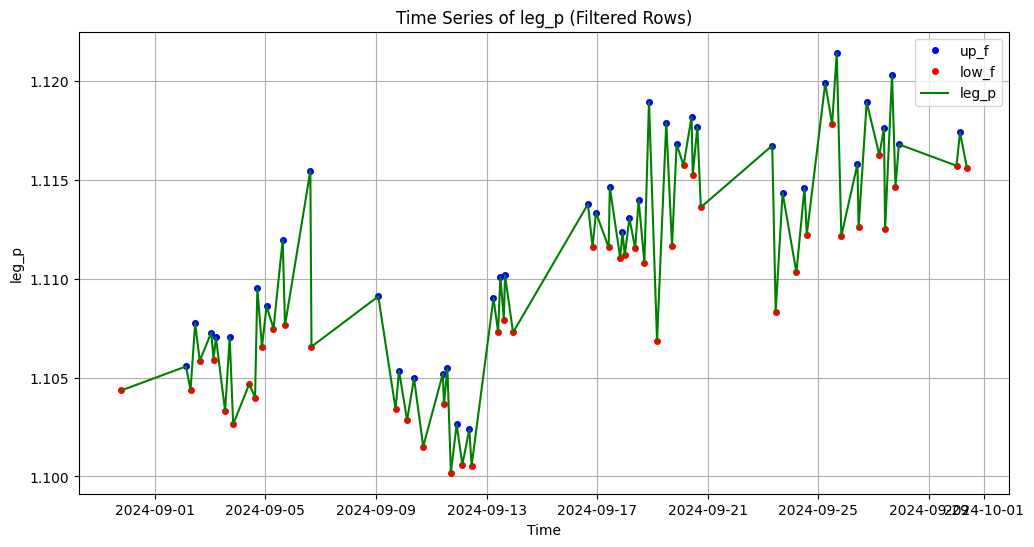

In [9]:
# انتخاب ردیف‌های خاص از دیتافریم
subset_fractals = fractals.iloc[-500:]  # انتخاب ردیف‌های 10 تا 20
# حذف سطرهایی که مقدار 'fra' آن‌ها False است
filtered_fractals = subset_fractals[subset_fractals['frac']]

# رسم نمودار
plt.figure(figsize=(12, 6))

# رسم نقاط up_f به رنگ آبی
plt.plot(filtered_fractals['time'][filtered_fractals['up_f']], filtered_fractals['leg_p']
         [filtered_fractals['up_f']], 'o', markersize=4, color='blue', label='up_f')

# رسم نقاط low_f به رنگ قرمز
plt.plot(filtered_fractals['time'][filtered_fractals['low_f']], filtered_fractals['leg_p']
         [filtered_fractals['low_f']], 'o', markersize=4, color='red', label='low_f')

# رسم نمودار خطی برای leg_p و اتصال نقاط
plt.plot(filtered_fractals['time'], filtered_fractals['leg_p'],
         '-', color='green', label='leg_p')

plt.xlabel('Time')
plt.ylabel('leg_p')
plt.title('Time Series of leg_p (Filtered Rows)')
plt.legend()
plt.grid(True)
plt.show()

In [10]:

# پیمایش معکوس ستون leg_p و جایگزینی مقادیر None
previous_value = None
for i in range(len(fractals)-1, -1, -1):
    if fractals.loc[i, 'leg_p'] is not None:
        previous_value = fractals.loc[i, 'leg_p']
    else:
        fractals.loc[i, 'leg_p'] = previous_value

fractals[-50:]

,time,O,H,L,C,vol,up_f,low_f,fra,frac,leg_p
99949,2024-09-26 10:00:00,1.11535,1.11579,1.11337,1.11348,2561,True,False,True,True,1.11579
99950,2024-09-26 11:00:00,1.11345,1.11436,1.11258,1.11412,2698,False,True,True,True,1.11258
99951,2024-09-26 12:00:00,1.11414,1.11523,1.11414,1.11437,2013,False,False,False,False,1.11891
99952,2024-09-26 13:00:00,1.11437,1.11551,1.11397,1.11539,2067,False,False,False,False,1.11891
99953,2024-09-26 14:00:00,1.11540,1.11614,1.11481,1.11541,2153,False,False,False,False,1.11891
99954,2024-09-26 15:00:00,1.11541,1.11653,1.11374,1.11512,3427,False,False,False,False,1.11891
99955,2024-09-26 16:00:00,1.11513,1.11598,1.11347,1.11399,3643,False,False,False,False,1.11891
99956,2024-09-26 17:00:00,1.11400,1.11746,1.11258,1.11648,3696,False,True,True,False,1.11891
99957,2024-09-26 18:00:00,1.11647,1.11891,1.11642,1.11828,2731,True,False,True,True,1.11891
99958,2024-09-26 19:00:00,1.11829,1.11829,1.11663,1.11692,2279,False,False,False,False,1.11624


شروع فرایند یادگیری ماشین

In [11]:
# به دلیل وجود None و اینکه مقدار صفر مناسب است و باعث ایجاد اشتباه نمیشود با صفر جایگزین شد
fractals['leg_p'] = fractals['leg_p'].fillna(0)

# تبدیل نوع ستون به نوع مناسب
fractals['leg_p'] = fractals['leg_p'].infer_objects(copy=False)

fractals

C:\Users\rezas\AppData\Local\Temp\ipykernel_1928\464926547.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fractals['leg_p'] = fractals['leg_p'].fillna(0)


,time,O,H,L,C,vol,up_f,low_f,fra,frac,leg_p
0,2008-08-12 09:00:00,1.48740,1.49140,1.48540,1.49040,1224,False,False,False,False,1.49640
1,2008-08-12 10:00:00,1.49080,1.49130,1.48570,1.48680,1154,False,False,False,False,1.49640
2,2008-08-12 11:00:00,1.48670,1.49220,1.48670,1.48750,1211,False,False,False,False,1.49640
3,2008-08-12 12:00:00,1.48740,1.49040,1.48740,1.48900,727,False,False,False,False,1.49640
4,2008-08-12 13:00:00,1.48910,1.49090,1.48770,1.49010,729,False,False,False,False,1.49640
...,...,...,...,...,...,...,...,...,...,...,...
99994,2024-09-30 07:00:00,1.11582,1.11620,1.11582,1.11616,862,False,False,False,False,1.11561
99995,2024-09-30 08:00:00,1.11616,1.11693,1.11613,1.11666,1278,False,False,False,False,1.11561
99996,2024-09-30 09:00:00,1.11661,1.11689,1.11561,1.11681,1669,False,True,True,True,1.11561
99997,2024-09-30 10:00:00,1.11679,1.11755,1.11593,1.11722,2139,False,False,False,False,0.00000


In [12]:
fractals_data = fractals
fractals_data

,time,O,H,L,C,vol,up_f,low_f,fra,frac,leg_p
0,2008-08-12 09:00:00,1.48740,1.49140,1.48540,1.49040,1224,False,False,False,False,1.49640
1,2008-08-12 10:00:00,1.49080,1.49130,1.48570,1.48680,1154,False,False,False,False,1.49640
2,2008-08-12 11:00:00,1.48670,1.49220,1.48670,1.48750,1211,False,False,False,False,1.49640
3,2008-08-12 12:00:00,1.48740,1.49040,1.48740,1.48900,727,False,False,False,False,1.49640
4,2008-08-12 13:00:00,1.48910,1.49090,1.48770,1.49010,729,False,False,False,False,1.49640
...,...,...,...,...,...,...,...,...,...,...,...
99994,2024-09-30 07:00:00,1.11582,1.11620,1.11582,1.11616,862,False,False,False,False,1.11561
99995,2024-09-30 08:00:00,1.11616,1.11693,1.11613,1.11666,1278,False,False,False,False,1.11561
99996,2024-09-30 09:00:00,1.11661,1.11689,1.11561,1.11681,1669,False,True,True,True,1.11561
99997,2024-09-30 10:00:00,1.11679,1.11755,1.11593,1.11722,2139,False,False,False,False,0.00000


نرمال سازی داده ها

In [13]:
from sklearn.preprocessing import MinMaxScaler
# در صورت تغییر به feature_range مورد نظر
scaler = MinMaxScaler(feature_range=(0, 1))

# انتخاب ستون‌هایی که می‌خواهیم نرمال کنیم
features_to_scale = ['O', 'H', 'L', 'C', 'vol', 'leg_p']

# اعمال MinMaxScaler به ستون‌های مورد نظر
fractals[features_to_scale] = scaler.fit_transform(fractals[features_to_scale])

# نمایش دیتا فریم نرمال شده
fractals[-50:]

,time,O,H,L,C,vol,up_f,low_f,fra,frac,leg_p
99949,2024-09-26 10:00:00,0.288131,0.286287,0.285564,0.284786,0.019269,True,False,True,True,0.736801
99950,2024-09-26 11:00:00,0.284740,0.283727,0.284152,0.285928,0.020301,False,True,True,True,0.734682
99951,2024-09-26 12:00:00,0.285972,0.285285,0.286940,0.286375,0.015145,False,False,False,False,0.738862
99952,2024-09-26 13:00:00,0.286382,0.285786,0.286636,0.288195,0.015551,False,False,False,False,0.738862
99953,2024-09-26 14:00:00,0.288221,0.286914,0.288137,0.288231,0.016198,False,False,False,False,0.738862
99954,2024-09-26 15:00:00,0.288238,0.287612,0.286225,0.287713,0.025788,False,False,False,False,0.738862
99955,2024-09-26 16:00:00,0.287739,0.286628,0.285742,0.285696,0.027414,False,False,False,False,0.738862
99956,2024-09-26 17:00:00,0.285722,0.289278,0.284152,0.290140,0.027813,False,True,True,False,0.738862
99957,2024-09-26 18:00:00,0.290130,0.291874,0.291014,0.293352,0.020549,True,False,True,True,0.738862
99958,2024-09-26 19:00:00,0.293379,0.290764,0.291389,0.290925,0.017147,False,False,False,False,0.737099


ساخت مدل RNN

ترین و تست 

روش 1- ترین و تست به روش تقسیم ساده

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1147 - val_loss: 2.5235e-04 - learning_rate: 0.0010
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step
Mean Absolute Error: 0.010727978311479092


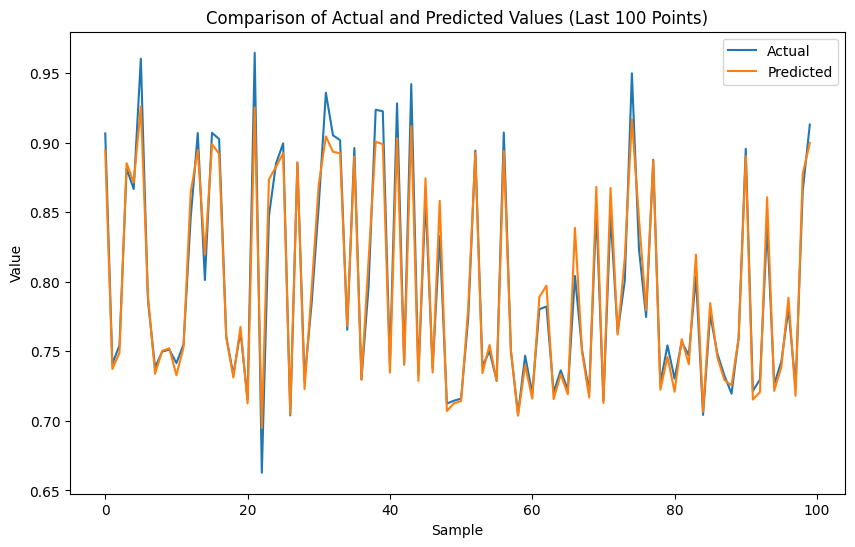

In [14]:
# آماده‌سازی داده‌ها
sequence_length = 1
features = ['O', 'H', 'L', 'C', 'vol']
X = np.array([fractals[features].iloc[i:i +
             sequence_length].values for i in range(len(fractals) - sequence_length)])
X = X.astype(np.float32)  # تبدیل نوع داده‌ها به float32
y = fractals['leg_p'].iloc[sequence_length:].astype(
    np.float32).values  # تبدیل y به float32

# تقسیم داده‌ها به مجموعه‌های آموزشی و تست
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# ساخت مدل
model = Sequential()
model.add(Input(shape=(sequence_length, len(features))))
model.add(LSTM(4, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(2))
model.add(Dense(1))

# کامپایل مدل
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# تنظیمات توقف زودهنگام و کاهش نرخ یادگیری
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# آموزش مدل
history = model.fit(X_train, y_train, validation_data=(
    X_test, y_test), epochs=1, batch_size=32, callbacks=[early_stopping, reduce_lr])

# پیش‌بینی روی مجموعه تست
predictions = model.predict(X_test)

# محاسبه خطای مطلق میانگین
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae}')

# ترسیم نمودار مقایسه
plt.figure(figsize=(10, 6))
plt.plot(y_test[-100:], label='Actual')
plt.plot(predictions[-100:], label='Predicted')
plt.title('Comparison of Actual and Predicted Values (Last 100 Points)')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

In [15]:


# فرض کنیم که شما در زمان نرمال‌سازی از 6 ویژگی استفاده کردید.
# بنابراین X_test باید تنها شامل ویژگی‌های مورد استفاده باشد.

# تغییر شکل X_test به ابعاد صحیح
X_test_full = np.concatenate([X_test.reshape(
    # ترکیب ویژگی‌ها و y_test
    X_test.shape[0], -1), y_test.reshape(-1, 1)], axis=1)

# تأیید اینکه تعداد ستون‌ها با تعداد ویژگی‌های نرمال‌سازی شده مطابقت دارد
print(f"Shape of X_test_full: {X_test_full.shape}")  # بررسی شکل

# نرمال‌سازی معکوس y_test
y_test_scaled_back = scaler.inverse_transform(
    X_test_full[:, :6])[:, -1]  # تنها ویژگی‌های اولیه را معکوس کنید

# نرمال‌سازی معکوس predictions
predictions_full = np.concatenate([X_test.reshape(
    X_test.shape[0], -1), predictions], axis=1)  # تغییر شکل برای ترکیب
predictions_scaled_back = scaler.inverse_transform(predictions_full[:, :6])[
    :, -1]  # تنها ویژگی‌های اولیه را معکوس کنید

# نمایش نتایج برای 5 ردیف آخر
print("\nLast 5 Predictions:")
for i in range(-5, 0):
    print(f'Actual (original scale): {
          y_test_scaled_back[i]}, Predicted (original scale): {predictions_scaled_back[i]}')

Shape of X_test_full: (20000, 6)

Last 5 Predictions:
Actual (original scale): 1.1245100498199463, Predicted (original scale): 1.1187466382980347
Actual (original scale): 1.1820600032806396, Predicted (original scale): 1.1941547393798828
Actual (original scale): 1.0967299938201904, Predicted (original scale): 1.0873173475265503
Actual (original scale): 1.3098100423812866, Predicted (original scale): 1.3286856412887573
Actual (original scale): 1.3825100660324097, Predicted (original scale): 1.3625717163085938


In [35]:
fractals

,data,predictions,predictions_scaled_back
0,0.0,None,NaN
1,1.0,None,NaN
2,2.0,None,NaN
3,3.0,None,NaN
4,4.0,None,NaN
...,...,...,...
20095,NaN,NaN,1.118747
20096,NaN,NaN,1.194155
20097,NaN,NaN,1.087317
20098,NaN,NaN,1.328686


In [34]:
# تابع برای پیدا کردن مکان مناسب و نوشتن پیش‌بینی
def assign_predictions(fractals, predictions_scaled_back, start_index=100):
    predicted_index = 0  # ایندکس پیش‌بینی برای پیمایش در predictions

    for i in range(start_index, start_index + len(predictions_scaled_back)):
        if predicted_index < len(predictions_scaled_back):
            fractals.at[i, 'predictions_scaled_back'] = predictions_scaled_back[predicted_index]
            predicted_index += 1
        else:
            break  # اگر پیش‌بینی‌ها تمام شدند، حلقه را متوقف کنید

    return fractals

# فراخوانی تابع برای تخصیص پیش‌بینی‌ها
fractals = assign_predictions(fractals, predictions_scaled_back)

# نمایش دیتافریم جدید
fractals


,data,predictions,predictions_scaled_back
0,0.0,None,NaN
1,1.0,None,NaN
2,2.0,None,NaN
3,3.0,None,NaN
4,4.0,None,NaN
...,...,...,...
20095,NaN,NaN,1.118747
20096,NaN,NaN,1.194155
20097,NaN,NaN,1.087317
20098,NaN,NaN,1.328686


روش 2- ترین و تست به روش کراس ولیدیشن

# آماده‌سازی داده‌ها
sequence_length = 20
features = ['O', 'H', 'L', 'C', 'vol']
X = np.array([fractals[features].iloc[i:i +
             sequence_length].values for i in range(len(fractals) - sequence_length)])
X = X.astype(np.float32)  # تبدیل نوع داده‌ها به float32
y = fractals['leg_p'].iloc[sequence_length:].astype(
    np.float32).values  # تبدیل y به float32

# تعریف Cross-Validation
kf = KFold(n_splits=3)
fold = 1

for train_index, test_index in kf.split(X):
    print(f'Fold {fold}')

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # ساخت مدل
    model = Sequential()
    model.add(Input(shape=(sequence_length, len(features))))
    model.add(LSTM(50, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(LSTM(20))
    model.add(Dense(1))

    # کامپایل مدل
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error')

    # تنظیمات توقف زودهنگام و کاهش نرخ یادگیری
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    # آموزش مدل
    history = model.fit(X_train, y_train, validation_data=(
        X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping, reduce_lr])

    # پیش‌بینی روی مجموعه تست
    predictions = model.predict(X_test)

    # ترسیم نمودار مقایسه
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_scaled_back[-100:-10], label='Actual')
    plt.plot(predictions_scaled_back[-100:], label='Predicted')
    plt.title(f'Comparison of Actual and Predicted Values for Fold {
              fold} (Last 100 Points)')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    fold += 1